
# Step 1: IMPORTING LIBRARIES

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visual Settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# STEP 2: LOAD DATA

In [230]:
# Load Data
df = pd.read_csv('StudentsPerformance.csv')

# Define Target
y = df['writing score']

# Preview
print(f"Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head())

Data Loaded: 1000 rows, 8 columns


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# STEP 3: PREPROCESSING SETUP


In [231]:
# Define Features
numeric_features = ['math score', 'reading score']
categorical_features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# Create Transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing Pipeline Created.")

Preprocessing Pipeline Created.


# STEP 4: SPLIT AND TRANSFORM

In [232]:
# --- 1. SIMPLE MODEL (Reading -> Writing) ---
X_slr = df[['reading score']]
X_train_slr, X_test_slr, y_train_slr, y_test_slr = train_test_split(X_slr, y, test_size=0.2, random_state=42)

model_slr = LinearRegression()
model_slr.fit(X_train_slr, y_train_slr)
y_pred_slr = model_slr.predict(X_test_slr)

# Metrics for Simple
r2_slr = r2_score(y_test_slr, y_pred_slr)
rmse_slr = np.sqrt(mean_squared_error(y_test_slr, y_pred_slr))


# --- 2. MULTIPLE MODEL (All Features -> Writing) ---
X_mlr = df.drop(columns=['writing score'])
X_train_raw, X_test_raw, y_train_mlr, y_test_mlr = train_test_split(X_mlr, y, test_size=0.2, random_state=42)

# Process Data
X_train_mlr = preprocessor.fit_transform(X_train_raw)
X_test_mlr = preprocessor.transform(X_test_raw)

model_mlr = LinearRegression()
model_mlr.fit(X_train_mlr, y_train_mlr)
y_pred_mlr = model_mlr.predict(X_test_mlr)

# Metrics for Multiple
r2_mlr = r2_score(y_test_mlr, y_pred_mlr)
rmse_mlr = np.sqrt(mean_squared_error(y_test_mlr, y_pred_mlr))

print("--- FINAL RESULTS ---")
print(f"Simple Model Accuracy (R2):   {r2_slr:.4f}  (Error: {rmse_slr:.2f})")
print(f"Multiple Model Accuracy (R2): {r2_mlr:.4f}  (Error: {rmse_mlr:.2f})")

--- FINAL RESULTS ---
Simple Model Accuracy (R2):   0.9010  (Error: 4.89)
Multiple Model Accuracy (R2): 0.9381  (Error: 3.86)


# STEP 5: EVALUATE & VISUALIZE


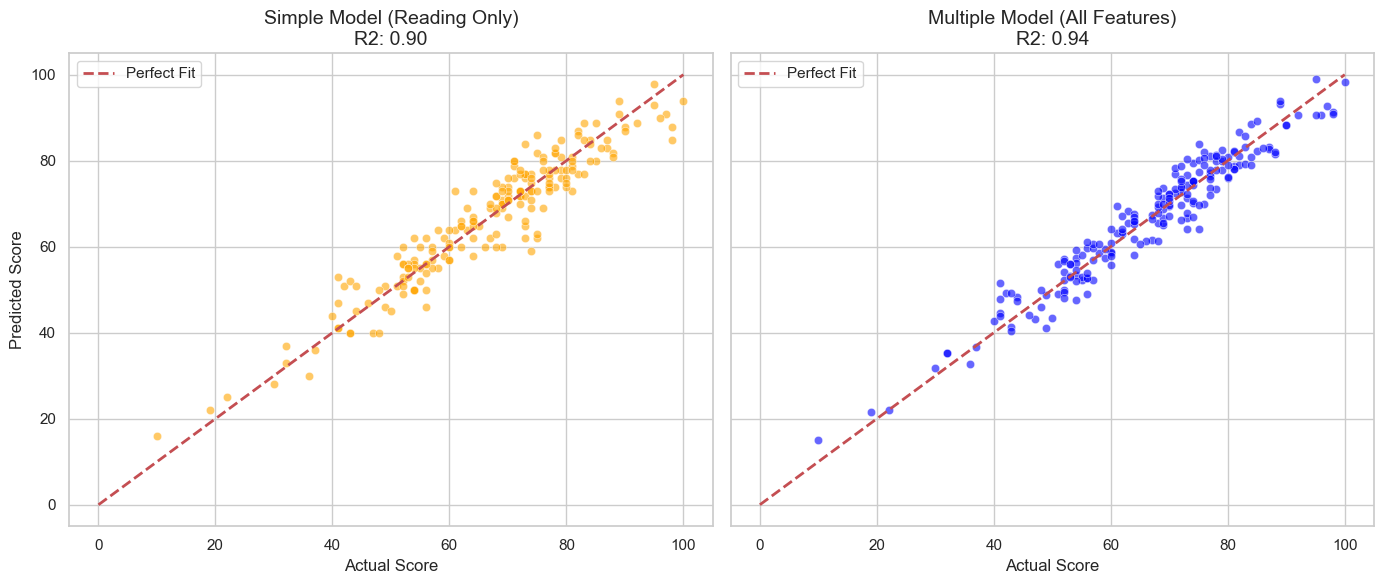

In [233]:
fig, axes = plt.subplots(1, 2, sharey=True)
perfect_line = [0, 100]

# Graph 1: Simple
sns.scatterplot(x=y_test_slr, y=y_pred_slr, color='orange', alpha=0.6, ax=axes[0])
axes[0].plot(perfect_line, perfect_line, 'r--', lw=2, label='Perfect Fit')
axes[0].set_title(f'Simple Model (Reading Only)\nR2: {r2_slr:.2f}', fontsize=14)
axes[0].set_xlabel('Actual Score')
axes[0].set_ylabel('Predicted Score')
axes[0].legend()

# Graph 2: Multiple
sns.scatterplot(x=y_test_mlr, y=y_pred_mlr, color='blue', alpha=0.6, ax=axes[1])
axes[1].plot(perfect_line, perfect_line, 'r--', lw=2, label='Perfect Fit')
axes[1].set_title(f'Multiple Model (All Features)\nR2: {r2_mlr:.2f}', fontsize=14)
axes[1].set_xlabel('Actual Score')
axes[1].legend()

plt.tight_layout()
plt.show()

# Step 6: Feature Importance

C:\Users\ebrah\AppData\Local\Temp\ipykernel_11216\3995537901.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Impact', y='Feature', data=coef_df, palette='viridis')


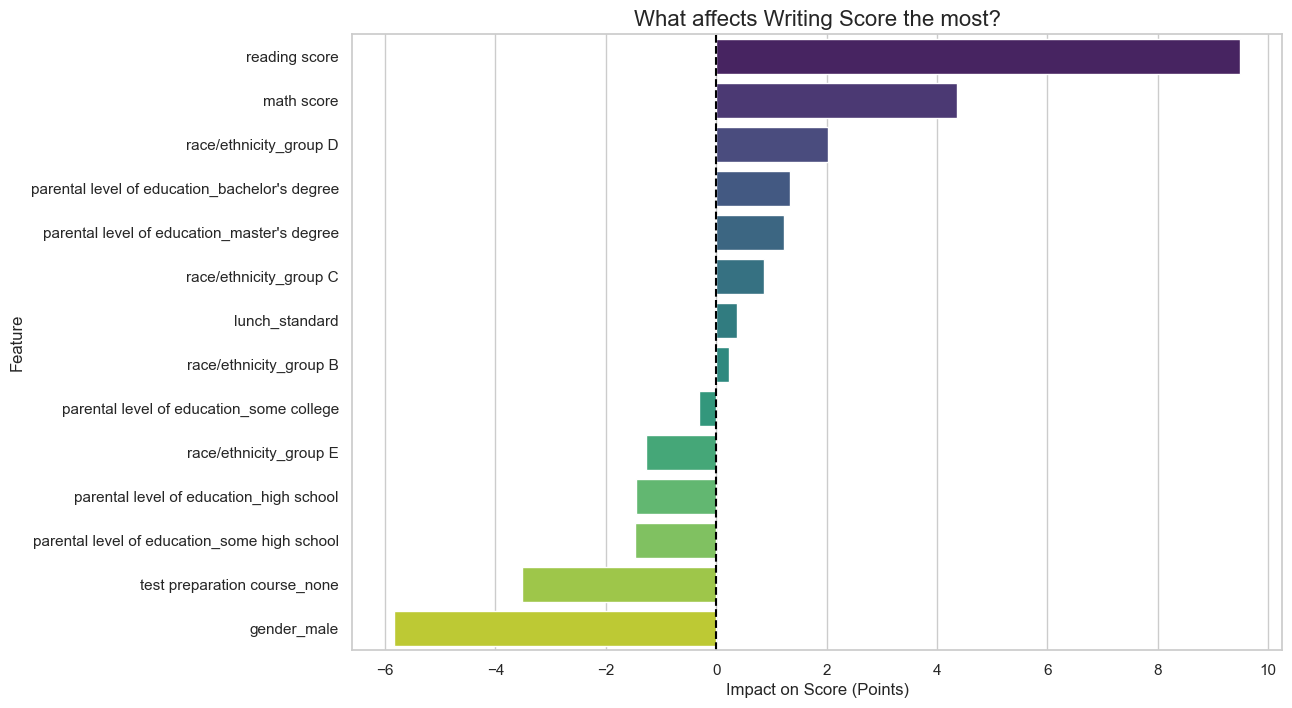

In [234]:
# Get feature names from the preprocessor
feature_names = (numeric_features + 
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Create a DataFrame of Coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Impact': model_mlr.coef_
})

# Sort by impact
coef_df = coef_df.sort_values(by='Impact', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Impact', y='Feature', data=coef_df, palette='viridis')
plt.title('What affects Writing Score the most?', fontsize=16)
plt.xlabel('Impact on Score (Points)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()